## 实例：使用kNN算法改进dating website的配对效果

kNN-1中已解决了构造分类器将匹配对象划分到确切的分类中。在该实例中，收集的数据是：文本文件。

特征①：每年获得的飞行常客里程数

特征②：玩视频游戏所耗时间百分比

特征③：每周消耗的icecream公升数

### 使用k-近邻法开发ML学习程序的流程
1、**收集数据**：提供文本文件

2、**准备数据**：使用python解析文本文件（确保数据符合计算机处理格式）

3、**分析数据**：使用matplotlib画二维扩散图

4、**训练算法**：此步骤不适用于k-近邻法（？？）

5、**测试算法**：使用提供的部分数据作为测试样本

6、**使用算法**：产生简单的命令行程序，然后可以输入一些特征数据以判断对方是否为自己喜欢的类型


### 数据处理
输入数据前，需要将raw数据转化为分类器可处理的格式，如训练样本矩阵、分类标签向量。具体是在kNN实现代码上创建新函数**file2matrix**的函数，以此来处理输入格式。该函数的输入为文件名字符串，输出为训练样本矩阵和分类标签向量。

In [1]:
import numpy as np
import operator

#### kNN：

In [2]:

"""
Parameters:
    inX - 用于分类的数据(测试集)
    dataSet - 用于训练的数据(训练集)
    labes - 分类标签
    k - kNN算法参数,选择距离最小的k个点
Returns:
    sortedClassCount[0][0] - 分类结果
"""
# 函数说明:kNN算法,分类器
def classify0(inX, dataSet, labels, k):
    # distance caculation:
    dataSetSize = dataSet.shape[0]
    diffMat = np.tile(inX, (dataSetSize, 1)) - dataSet
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1)
    distances = sqDistances**0.5
    
    # k nearest neighbour:
    sortedDistIndices = distances.argsort()
    classCount = {}
    for i in range(k):
        voteIlabel = labels[sortedDistIndices[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
        
    # Descending sort:
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0]

#### 准备数据：
将文本文件解析为**特征矩阵**、**分类标签向量**

In [3]:
def file2matrix(filename):
    fr = open(filename)
    arrayOLines = fr.readlines()
    numberOfLines = len(arrayOLines)
    returnMat = np.zeros((numberOfLines,3))
    classLabelVector = []
    index = 0
    for line in arrayOLines:
        line = line.strip()
        listFromLine = line.split('\t')
        returnMat[index,:] = listFromLine[0:3]
        if listFromLine[-1] == 'didntLike':
            classLabelVector.append(1)
        elif listFromLine[-1] == 'smallDoses':
            classLabelVector.append(2)
        elif listFromLine[-1] == 'largeDoses':
            classLabelVector.append(3)
        index += 1
    return returnMat, classLabelVector

In [4]:
datingDataMat, datingLabels = file2matrix('.\dataSet\datingTestSet.txt')
datingDataMat

array([[4.0920000e+04, 8.3269760e+00, 9.5395200e-01],
       [1.4488000e+04, 7.1534690e+00, 1.6739040e+00],
       [2.6052000e+04, 1.4418710e+00, 8.0512400e-01],
       ...,
       [2.6575000e+04, 1.0650102e+01, 8.6662700e-01],
       [4.8111000e+04, 9.1345280e+00, 7.2804500e-01],
       [4.3757000e+04, 7.8826010e+00, 1.3324460e+00]])

In [5]:
datingLabels[0:25]

[3, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 3, 2]

为了直观看到数据模式，需要利用样本分类的特征值标记为不同颜色以区分散点图上的点。具体方法是使用matplotlib的方法scatter：``scatter(x, y, size, color)``，以下x=矩阵datingMat第二列数据（玩视频游戏所耗时间百分比），y=矩阵第三列数据（每周所消费的冰淇淋公升数）

**size**：点的大小，默认 20，也可以是个数组，数组每个参数为对应点的大小。

**color**：点的颜色，默认蓝色 'b'，也可以是个 RGB 或 RGBA 二维行数组。

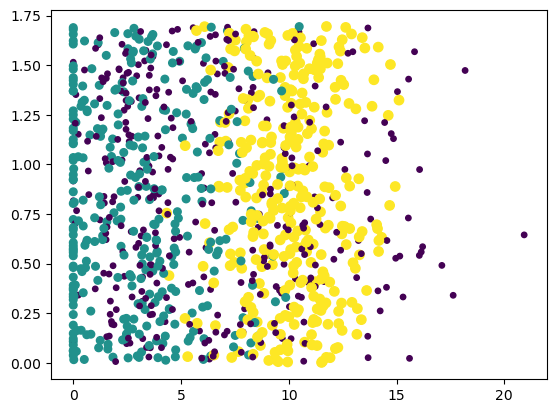

In [6]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(datingDataMat[:,1], datingDataMat[:,2], 15.0*np.array(datingLabels), 15.0*np.array(datingLabels))
plt.show()

### 分析数据

#### 发现问题：
在表中给出了提取的四组数据：

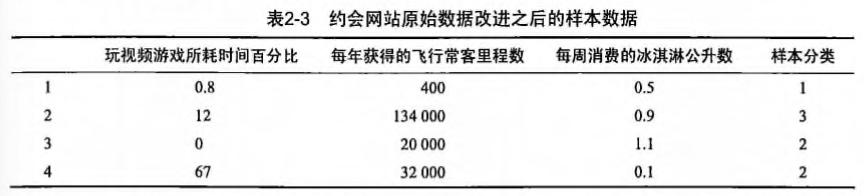

如果计算样本3、4之间的距离，可以使用下面的方法：
$$\sqrt{(0-67)^2+(20000-32000)^2+(1.1-0.1)^2}$$
**观察数据发现**：上面方程中数字数值最大的属性$(20000-32000)^2$对计算结果影响最大。也就是说，仅仅因为数值远远大于其他特征值，每年获取的飞行常客里程数对于计算结果的影响将也远大于表中其他两个特征（玩视频游戏和每周消费冰淇淋公升数）

#### 解决方法：
在处理这种不同取值范围的特征值时，通常采用的方法是将数值**归一化**，如将取值范围处理为0到1或者1到-1之间。

将任意数值范围的特征值转化为\[0,1\]区间内的值：
```
newValue = (oldValue-min)/(max-min)
```
其中**min和max分别是数据集中的最小特征值和最大特征值**。虽然改变数值取值范围增加了分类器的复杂度，但是能得到准确的结果。

#### 代码实现：

在kNN算法代码基础上增加新函数autoNorm()，该函数实现自动将数字特征值转化为0到1的区间.


python中，假设A为矩阵：
```
A.min(0)表示返回A每一列最小值的数组;
A.min(1)表示返回A每一行最小值的数组;
A.max(0)表示返回A每一列最大值的数组;
A.max(1)表示返回A每一行最大值的数组;
```
<mark>这里**归一化处理将由矩阵运算**完成：（将min、（max-min）展开成一个矩阵，然后与特征矩阵进行计算，避免使用复杂的for语句实现）</mark>

In [7]:
def autoNorm(dataSet):
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = np.zeros(np.shape(dataSet))
    m = dataSet.shape[0]
    normDataSet = dataSet - np.tile(minVals, (m,1))
    # 特征值相除
    normDataSet = normDataSet/np.tile(ranges, (m,1))
    return normDataSet, ranges, minVals

In [8]:
norMat, ranges, minVals = autoNorm(datingDataMat)
norMat

array([[0.44832535, 0.39805139, 0.56233353],
       [0.15873259, 0.34195467, 0.98724416],
       [0.28542943, 0.06892523, 0.47449629],
       ...,
       [0.29115949, 0.50910294, 0.51079493],
       [0.52711097, 0.43665451, 0.4290048 ],
       [0.47940793, 0.3768091 , 0.78571804]])

In [9]:
ranges

array([9.1273000e+04, 2.0919349e+01, 1.6943610e+00])

In [10]:
minVals

array([0.      , 0.      , 0.001156])

### 测试算法
通常只提供已有数据的90%作为训练样本来训练分类器，而使用其余的10%数据去测试分类器，检测分类器的正确率。该10%数据应该是随机选择。

为测试分类器效果，创建新函数datingClassTest：

In [11]:
def datingClassTest():
    # error rate is between 0 and 1
    hoRatio =0.10
    datingDataMat, datingLabels = file2matrix('.\dataSet\datingTestSet.txt')
    normMat, ranges, minVals = autoNorm(datingDataMat)
    m = normMat.shape[0]
    numTestVecs = int(m*hoRatio)
    errorCount = 0.0
    for i in range(numTestVecs):
        classifierResult = classify0(normMat[i,:],normMat[numTestVecs:m,:],datingLabels[numTestVecs:m],3)
        print("the classifier came back with: %d, the real answer is: %d" % (classifierResult, datingLabels[i]))
        if (classifierResult != datingLabels[i]) : errorCount += 1.0
    print("the total error rate is: %f" % (errorCount/float(numTestVecs)))

In [12]:
datingClassTest()

the classifier came back with: 3, the real answer is: 3
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answe

此时分类器处理约会数据集的错误率为5%。可以改变函数datingClassTest内变量hoRatio和变量k的值，观察检测错误率是否随着变量值的变化而增加。依赖于分类算法、数据集、程序设置，分类器的输出结果可能有很大的不同。

### 使用算法：构建完整可用系统
为了方便用户使用，通过以下程序用户可在约会网站上找到某个人并输入他的信息，程序会给出对对方喜欢程度的预测值。

In [13]:
def classifyPerson():
    resultList = ['not at all','in small doses','in large doses']
    percentTats = float(input("玩电子游戏所耗时间百分比？"))
    ffMiles = float(input("每年获得的飞行常客里程数？"))
    iceCream = float(input("每年消耗的冰淇淋公升数?"))
    datingDataMat, datingLabels = file2matrix('.\dataSet\datingTestSet.txt')
    normMat, ranges, minVals = autoNorm(datingDataMat)
    inArr = np.array([ffMiles, percentTats, iceCream])
    classifierResult = classify0((inArr - minVals) / ranges, normMat, datingLabels, 3)
    print("You will probably like this person: ",resultList[classifierResult-1])

In [14]:
classifyPerson()

玩电子游戏所耗时间百分比？10
每年获得的飞行常客里程数？10000
每年消耗的冰淇淋公升数?0.5
You will probably like this person:  in small doses
